**Predicting whether an applicant is capable of repaying a loan**

**Overview: Implement multi-class predictive 3 models to predict repayment loan rate in different lending process**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split,  StratifiedKFold
from sklearn.metrics import classification_report,  roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
# , StandardScaler
# from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [4]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [5]:
import optuna
import joblib
import shap

In [6]:
from utils import *

In [7]:
df = pd.read_parquet(f'../intermediate/data_modelling.parquet')

In [8]:
#config
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 1. label encode

In [9]:
df = df[df['categorize_status'].isin(['withdrawl_or_cancel', 'repayment_completed','loan_in_default'])].reset_index(drop = True)

In [10]:
df['target'] = df['categorize_status'].map(label_encode)

In [11]:
df['target'].value_counts()

target
2    537585
1     18076
0     11455
Name: count, dtype: int64

Train predictive models in different period of lending processing: 
* Model 1. Accepted loan application
* Model 2. Originate application
* Model 3. After 1st payment

# 2. Model 1: Predict repayment once applicant submit their application

In [12]:
df_1 = df[df['categorize_status'].isin(['withdrawl_or_cancel', 'repayment_completed','loan_in_default'])].reset_index(drop = True)
df_1 = df_1.fillna(0)

In [13]:
# I assume that interest rate, no of installment might not available at that process
features = ['payFrequency', 'apr', 'nPaidOff','loanAmount','state', 'leadType', 'leadCost']
target = 'target'

In [14]:
X_full = df_1[features]
y_full = df_1[target].astype('int32')

In [15]:
categorical_features = []
label_encoders = {}
for c in X_full.columns:
    col_type = X_full[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        categorical_features.append(c)
        X_full[c]  = X_full[c].astype(str)
        le = LabelEncoder()
        X_full[c] = le.fit_transform(X_full[c])
        label_encoders[c] = le
        X_full[c] = X_full[c].astype('category')
        print(c)

payFrequency
state
leadType


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42,test_size=0.20, stratify=y_full)
df_train = X_train.merge(y_train, left_index = True, right_index = True).reset_index(drop = True)

X = df_train[features]
y = df_train[target].astype('int32')

## stratifiedKF, hyper-parameter tuning, undersampling techniques

In [17]:
X = X.values
# Optuna objective function
def objective(trial):
    # Hyperparameters to optimize
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Number of unique classes
        'metric': 'multi_logloss', # or 'multi_logloss' for multiclass
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose':0
    }
    
    # To store cross-validation accuracy
    accuracies = []
    # aucs = []
    
    # Cross-validation loop
    for train_idx, val_idx in skf.split(X, y):
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply SMOTE to training data only
        # X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train_res, label=y_train_res)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Train model
        model = lgb.train(param, train_data, valid_sets=[val_data], 
                          num_boost_round=10, callbacks=[lgb.early_stopping(stopping_rounds=3)]) #, early_stopping_rounds=100, verbose_eval=False
        
        # Predict and calculate accuracy for this fold
        y_pred = model.predict(X_val)
        # y_pred_binary = np.round(y_pred)  # For binary classification
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        accuracy = accuracy_score(y_val, y_pred_labels)
        # auc = roc_auc_score(y_val, y_pred_labels, multi_class='ovr')
        accuracies.append(accuracy)
        # aucs.append(auc)
    
    # Return the average accuracy across folds
    return np.mean(accuracies)

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=10)  

# Extract best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)


[I 2024-10-08 22:50:23,716] A new study created in memory with name: no-name-7d181981-f373-4369-bad3-7058431abe31


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:24,442] Trial 0 finished with value: 0.7242821138545281 and parameters: {'learning_rate': 0.09656691670627414, 'num_leaves': 101, 'min_data_in_leaf': 37, 'max_depth': 7, 'feature_fraction': 0.8645645916633666, 'bagging_fraction': 0.9595299870615088, 'bagging_freq': 2}. Best is trial 0 with value: 0.7242821138545281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:24,974] Trial 1 finished with value: 0.7619309994358844 and parameters: {'learning_rate': 0.02031180107997702, 'num_leaves': 112, 'min_data_in_leaf': 40, 'max_depth': 4, 'feature_fraction': 0.8541989452670811, 'bagging_fraction': 0.9861096344683138, 'bagging_freq': 1}. Best is trial 1 with value: 0.7619309994358844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:25,562] Trial 2 finished with value: 0.7604145534710364 and parameters: {'learning_rate': 0.06874004665578749, 'num_leaves': 105, 'min_data_in_leaf': 38, 'max_depth': 5, 'feature_fraction': 0.7750373605538148, 'bagging_fraction': 0.8950334573417008, 'bagging_freq': 1}. Best is trial 1 with value: 0.7619309994358844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:26,041] Trial 3 finished with value: 0.7643952532362834 and parameters: {'learning_rate': 0.07739374902214179, 'num_leaves': 68, 'min_data_in_leaf': 34, 'max_depth': 3, 'feature_fraction': 0.8865355252774224, 'bagging_fraction': 0.7820600545864351, 'bagging_freq': 7}. Best is trial 3 with value: 0.7643952532362834.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:26,779] Trial 4 finished with value: 0.7236230893687944 and parameters: {'learning_rate': 0.010403857579220969, 'num_leaves': 94, 'min_data_in_leaf': 30, 'max_depth': 8, 'feature_fraction': 0.8765208649301406, 'bagging_fraction': 0.8567157014680946, 'bagging_freq': 1}. Best is trial 3 with value: 0.7643952532362834.


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 1.05757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-10-08 22:50:27,565] Trial 5 finished with value: 0.7130983239765384 and parameters: {'learning_rate': 0.09904276845355585, 'num_leaves': 140, 'min_data_in_leaf': 50, 'max_depth': 9, 'feature_fraction': 0.8337998086906075, 'bagging_fraction': 0.9206643291080993, 'bagging_freq': 6}. Best is trial 3 with value: 0.7643952532362834.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:28,425] Trial 6 finished with value: 0.7166690260428393 and parameters: {'learning_rate': 0.04907623788250509, 'num_leaves': 148, 'min_data_in_leaf': 36, 'max_depth': 9, 'feature_fraction': 0.8518138038294286, 'bagging_fraction': 0.9247960581920677, 'bagging_freq': 2}. Best is trial 3 with value: 0.7643952532362834.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.949614
[LightGBM] [Warning] No furt

[I 2024-10-08 22:50:28,936] Trial 7 finished with value: 0.7564779716200863 and parameters: {'learning_rate': 0.01424552077511635, 'num_leaves': 61, 'min_data_in_leaf': 24, 'max_depth': 3, 'feature_fraction': 0.9306798759903887, 'bagging_fraction': 0.912833809901806, 'bagging_freq': 1}. Best is trial 3 with value: 0.7643952532362834.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:50:29,451] Trial 8 finished with value: 0.7902806490123555 and parameters: {'learning_rate': 0.08503296279019257, 'num_leaves': 89, 'min_data_in_leaf': 38, 'max_depth': 3, 'feature_fraction': 0.7743055466308911, 'bagging_fraction': 0.7862039192961046, 'bagging_freq': 1}. Best is trial 8 with value: 0.7902806490123555.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.937023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-10-08 22:50:30,263] Trial 9 finished with value: 0.7131247690182402 and parameters: {'learning_rate': 0.07771940545156096, 'num_leaves': 108, 'min_data_in_leaf': 32, 'max_depth': 10, 'feature_fraction': 0.8358551923079434, 'bagging_fraction': 0.7998770079602641, 'bagging_freq': 4}. Best is trial 8 with value: 0.7902806490123555.


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.900606
Best hyperparameters:  {'learning_rate': 0.08503296279019257, 'num_leaves': 89, 'min_data_in_leaf': 38, 'max_depth': 3, 'feature_fraction': 0.7743055466308911, 'bagging_fraction': 0.7862039192961046, 'bagging_freq': 1}


In [18]:
joblib.dump(best_params, f'../model/lgb_1.pkl')

['../model/lgb_1.pkl']

In [19]:
X_res, y_res = rus.fit_resample(X, y)
# Create final LightGBM dataset
final_data = lgb.Dataset(X_res, label=y_res)

# Train the final model
final_model = lgb.train(best_params, final_data, num_boost_round=100)

# Save the final model
final_model.save_model(f'../model/final_lgb_model_optuna_v1.txt')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [20]:
X_test = X_test.values
# Create LightGBM datasets
X_res, y_res = rus.fit_resample(X, y)
train_data = lgb.Dataset(X_res, label=y_res)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train model
model1 = lgb.train(best_params, final_data, num_boost_round=100)

# Predict and calculate accuracy for this fold
y_pred = model1.predict(X_test)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [21]:
y_pred_ = [round(i) for i in y_pred]
df_y_pred = pd.DataFrame(y_pred_, columns=['target'])
df_y_pred['target'].value_counts(normalize = True)

target
1    0.831455
2    0.146609
0    0.021935
Name: proportion, dtype: float64

In [22]:
# Model performance
classification_report(y_test, y_pred_, output_dict=True)

{'0': {'precision': 0.3090836012861736,
  'recall': 0.3356612832824094,
  'f1-score': 0.32182464950826534,
  'support': 2291.0},
 '1': {'precision': 0.03191703691136395,
  'recall': 0.8326417704011065,
  'f1-score': 0.06147750250199138,
  'support': 3615.0},
 '2': {'precision': 0.9900174394130735,
  'recall': 0.1531185475920311,
  'f1-score': 0.2652178465850967,
  'support': 107518.0},
 'accuracy': 0.17846311186345043,
 'macro avg': {'precision': 0.44367269253687036,
  'recall': 0.44047386709184905,
  'f1-score': 0.21617333286511778,
  'support': 113424.0},
 'weighted avg': {'precision': 0.9457274092766614,
  'recall': 0.17846311186345043,
  'f1-score': 0.2598676988353837,
  'support': 113424.0}}

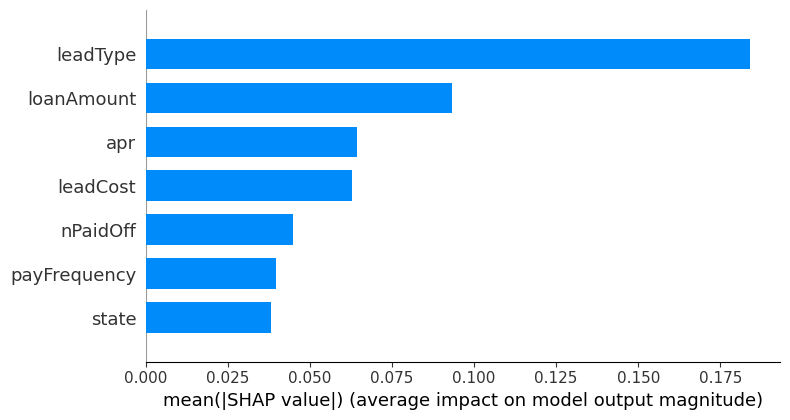

In [24]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features)

# 3. Model 2: Originated application

In [29]:
df_2 = df[(df['originated']==True) & (df['categorize_status'].isin(['withdrawl_or_cancel', 'repayment_completed','loan_in_default']))].reset_index(drop = True)
df_2 = df_2.fillna(0)

In [30]:
df_2['target'].value_counts()

target
1    18073
0    11453
2     6316
Name: count, dtype: int64

In [33]:
# Assume no 1st payment status available at that process
features = ['payFrequency', 'apr', 'nPaidOff','loanAmount', 'state', 'leadType', 'leadCost', 'clearfraudscore', 'interestrate_per_payment', 'no_installment'] #, 
target = 'target'

In [34]:
X_full = df_2[features]
y_full = df_2[target].astype('int32')

In [35]:
categorical_features = []
label_encoders = {}
for c in X_full.columns:
    col_type = X_full[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        categorical_features.append(c)
        X_full[c]  = X_full[c].astype(str)
        le = LabelEncoder()
        X_full[c] = le.fit_transform(X_full[c])
        label_encoders[c] = le
        X_full[c] = X_full[c].astype('category')
        print(c)

payFrequency
state
leadType


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42,test_size=0.20, stratify=y_full)
df_train = X_train.merge(y_train, left_index = True, right_index = True).reset_index(drop = True)

X = df_train[features]
y = df_train[target].astype('int32')

In [37]:
X = X.values
# Optuna objective function
def objective(trial):
    # Hyperparameters to optimize
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Number of unique classes
        'metric': 'multi_logloss', # or 'multi_logloss' for multiclass
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_pre_filter': False, 
        'verbose': 0
    }
    
    # To store cross-validation accuracy
    accuracies = []
    # aucs = []
    
    # Cross-validation loop
    for train_idx, val_idx in skf.split(X, y):
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply SMOTE to training data only
        # X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train_res, label=y_train_res)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Train model
        model = lgb.train(param, train_data, valid_sets=[val_data], 
                          num_boost_round=10, callbacks=[lgb.early_stopping(stopping_rounds=3)]) #, early_stopping_rounds=100, verbose_eval=False
        
        # Predict and calculate accuracy for this fold
        y_pred = model.predict(X_val)
        # y_pred_binary = np.round(y_pred)  # For binary classification
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        accuracy = accuracy_score(y_val, y_pred_labels)
        # auc = roc_auc_score(y_val, y_pred_labels, multi_class='ovr')
        accuracies.append(accuracy)
        # aucs.append(auc)
    
    # Return the average accuracy across folds
    return np.mean(accuracies)

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=10)  

# Extract best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=10)  

# Extract best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-10-08 22:57:09,697] A new study created in memory with name: no-name-9ef9356c-cdea-4ca7-9fb1-65faee4c6620
[I 2024-10-08 22:57:09,805] Trial 0 finished with value: 0.761587685810118 and parameters: {'learning_rate': 0.10608646664054373, 'num_leaves': 95, 'min_data_in_leaf': 21, 'max_depth': 5, 'feature_fraction': 0.93539531690839, 'bagging_fraction': 0.7461781771228801, 'bagging_freq': 1}. Best is trial 0 with value: 0.761587685810118.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:57:10,017] Trial 1 finished with value: 0.7861056113147292 and parameters: {'learning_rate': 0.2270545703874544, 'num_leaves': 91, 'min_data_in_leaf': 27, 'max_depth': 9, 'feature_fraction': 0.9968048052099231, 'bagging_fraction': 0.9501224325753533, 'bagging_freq': 4}. Best is trial 1 with value: 0.7861056113147292.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.475863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2024-10-08 22:57:10,156] Trial 2 finished with value: 0.7276884720903333 and parameters: {'learning_rate': 0.011460214033424, 'num_leaves': 131, 'min_data_in_leaf': 48, 'max_depth': 5, 'feature_fraction': 0.8551177839804609, 'bagging_fraction': 0.9592535507897713, 'bagging_freq': 4}. Best is trial 1 with value: 0.7861056113147292.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:57:10,317] Trial 3 finished with value: 0.7680400710825556 and parameters: {'learning_rate': 0.015893829502326495, 'num_leaves': 147, 'min_data_in_leaf': 40, 'max_depth': 8, 'feature_fraction': 0.9664672961082872, 'bagging_fraction': 0.9265211905097261, 'bagging_freq': 4}. Best is trial 1 with value: 0.7861056113147292.
[I 2024-10-08 22:57:10,455] Trial 4 finished with value: 0.7148537613210179 and parameters: {'learning_rate': 0.01622466560329581, 'num_leaves': 131, 'min_data_in_leaf': 46, 'max_depth': 4, 'feature_fraction': 0.9400129273865776, 'bagging_fraction': 0.7970439801714645, 'bagging_freq': 1}. Best is trial 1 with value: 0.7861056113147292.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:57:10,578] Trial 5 finished with value: 0.732361625885703 and parameters: {'learning_rate': 0.021476157176438995, 'num_leaves': 57, 'min_data_in_leaf': 34, 'max_depth': 5, 'feature_fraction': 0.8633454180364596, 'bagging_fraction': 0.9331824513611844, 'bagging_freq': 5}. Best is trial 1 with value: 0.7861056113147292.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-08 22:57:10,715] Trial 6 finished with value: 0.7687374685452627 and parameters: {'learning_rate': 0.08399819334152994, 'num_leaves': 37, 'min_data_in_leaf': 48, 'max_depth': 10, 'feature_fraction': 0.9774811636930409, 'bagging_fraction': 0.9272190223355237, 'bagging_freq': 4}. Best is trial 1 with value: 0.7861056113147292.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.531741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-10-08 22:57:10,984] Trial 7 finished with value: 0.7873612281662936 and parameters: {'learning_rate': 0.14062938465098346, 'num_leaves': 132, 'min_data_in_leaf': 22, 'max_depth': 9, 'feature_fraction': 0.9089172001569168, 'bagging_fraction': 0.9674074567695281, 'bagging_freq': 4}. Best is trial 7 with value: 0.7873612281662936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.523904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2024-10-08 22:57:11,177] Trial 8 finished with value: 0.7731317115241539 and parameters: {'learning_rate': 0.01825632822789738, 'num_leaves': 88, 'min_data_in_leaf': 39, 'max_depth': 9, 'feature_fraction': 0.9534908405855901, 'bagging_fraction': 0.739560295361131, 'bagging_freq': 3}. Best is trial 7 with value: 0.7873612281662936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.932726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-10-08 22:57:11,429] Trial 9 finished with value: 0.7789908858358897 and parameters: {'learning_rate': 0.039828109606616105, 'num_leaves': 127, 'min_data_in_leaf': 22, 'max_depth': 10, 'feature_fraction': 0.939968895272581, 'bagging_fraction': 0.8934586294288298, 'bagging_freq': 1}. Best is trial 7 with value: 0.7873612281662936.
[I 2024-10-08 22:57:11,429] A new study created in memory with name: no-name-f03ec90a-49cb-491f-8974-8ded41ccaf3b


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.797266
Best hyperparameters:  {'learning_rate': 0.14062938465098346, 'num_leaves': 132, 'min_data_in_leaf': 22

[I 2024-10-08 22:57:11,545] Trial 0 finished with value: 0.7676911223853379 and parameters: {'learning_rate': 0.07783602759554627, 'num_leaves': 26, 'min_data_in_leaf': 26, 'max_depth': 9, 'feature_fraction': 0.7764262906444549, 'bagging_fraction': 0.899966112426453, 'bagging_freq': 6}. Best is trial 0 with value: 0.7676911223853379.
[I 2024-10-08 22:57:11,719] Trial 1 finished with value: 0.776375213840323 and parameters: {'learning_rate': 0.052849658898972224, 'num_leaves': 65, 'min_data_in_leaf': 25, 'max_depth': 10, 'feature_fraction': 0.8569312591076599, 'bagging_fraction': 0.887015991355828, 'bagging_freq': 5}. Best is trial 1 with value: 0.776375213840323.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.743455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.745301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.739022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with posit

[I 2024-10-08 22:57:11,935] Trial 2 finished with value: 0.7791303448932657 and parameters: {'learning_rate': 0.05901644994222283, 'num_leaves': 103, 'min_data_in_leaf': 41, 'max_depth': 9, 'feature_fraction': 0.7916037326205925, 'bagging_fraction': 0.9851292687278459, 'bagging_freq': 5}. Best is trial 2 with value: 0.7791303448932657.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:57:12,060] Trial 3 finished with value: 0.769678843638791 and parameters: {'learning_rate': 0.090595063271634, 'num_leaves': 92, 'min_data_in_leaf': 21, 'max_depth': 6, 'feature_fraction': 0.778995964922454, 'bagging_fraction': 0.8003915622656453, 'bagging_freq': 2}. Best is trial 2 with value: 0.7791303448932657.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:57:12,311] Trial 4 finished with value: 0.7700277485463682 and parameters: {'learning_rate': 0.010352482373394072, 'num_leaves': 125, 'min_data_in_leaf': 40, 'max_depth': 9, 'feature_fraction': 0.9526394589556881, 'bagging_fraction': 0.7952942999485848, 'bagging_freq': 5}. Best is trial 2 with value: 0.7791303448932657.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 22:57:12,444] Trial 5 finished with value: 0.7828968195868784 and parameters: {'learning_rate': 0.2007229025676784, 'num_leaves': 48, 'min_data_in_leaf': 49, 'max_depth': 8, 'feature_fraction': 0.7981107691042363, 'bagging_fraction': 0.8265194820475086, 'bagging_freq': 4}. Best is trial 5 with value: 0.7828968195868784.
[I 2024-10-08 22:57:12,525] Trial 6 finished with value: 0.7037284995876001 and parameters: {'learning_rate': 0.022256923997987312, 'num_leaves': 94, 'min_data_in_leaf': 36, 'max_depth': 3, 'feature_fraction': 0.9264296362712837, 'bagging_fraction': 0.993324006303427, 'bagging_freq': 6}. Best is trial 5 with value: 0.7828968195868784.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.496948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-10-08 22:57:12,670] Trial 7 finished with value: 0.766191458569355 and parameters: {'learning_rate': 0.016643758472101665, 'num_leaves': 33, 'min_data_in_leaf': 39, 'max_depth': 9, 'feature_fraction': 0.849138946706017, 'bagging_fraction': 0.9966405200839383, 'bagging_freq': 4}. Best is trial 5 with value: 0.7828968195868784.


Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.956363
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.955748
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.800553
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.798747
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.798077


[I 2024-10-08 22:57:12,805] Trial 8 finished with value: 0.7642035658064769 and parameters: {'learning_rate': 0.04336807851954034, 'num_leaves': 27, 'min_data_in_leaf': 42, 'max_depth': 9, 'feature_fraction': 0.9374359743506744, 'bagging_fraction': 0.9078583007316304, 'bagging_freq': 3}. Best is trial 5 with value: 0.7828968195868784.
[I 2024-10-08 22:57:12,889] Trial 9 finished with value: 0.7185503295028126 and parameters: {'learning_rate': 0.07453706557432452, 'num_leaves': 121, 'min_data_in_leaf': 29, 'max_depth': 3, 'feature_fraction': 0.8744684593883444, 'bagging_fraction': 0.7603713492561269, 'bagging_freq': 1}. Best is trial 5 with value: 0.7828968195868784.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [38]:
joblib.dump(best_params, f'../model/lgb_2.pkl')

['../model/lgb_2.pkl']

In [39]:
X_res, y_res = rus.fit_resample(X, y)
# Create final LightGBM dataset
final_data = lgb.Dataset(X_res, label=y_res)

# Train the final model
final_model = lgb.train(best_params, final_data, num_boost_round=100)

# Save the final model
final_model.save_model(f'../model/final_lgb_model_optuna_v2.txt')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [42]:
X_test = X_test.values
# Create LightGBM datasets
X_res, y_res = rus.fit_resample(X, y)
train_data = lgb.Dataset(X_res, label=y_res)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train model
model2 = lgb.train(best_params, final_data, num_boost_round=100)

# Predict and calculate accuracy for this fold
y_pred = model2.predict(X_test)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [43]:
y_pred_ = [round(i) for i in y_pred]
df_y_pred = pd.DataFrame(y_pred_, columns=['target'])
df_y_pred['target'].value_counts(normalize = True)

target
1    0.471893
0    0.355838
2    0.172269
Name: proportion, dtype: float64

In [45]:
# Model performance much better than version 1

In [44]:
classification_report(y_test, y_pred_, output_dict=True)

{'0': {'precision': 0.6589572716581733,
  'recall': 0.7337407245744216,
  'f1-score': 0.6943411813300289,
  'support': 2291.0},
 '1': {'precision': 0.8137747561336092,
  'recall': 0.7615491009681881,
  'f1-score': 0.7867962274935696,
  'support': 3615.0},
 '2': {'precision': 0.9959514170040485,
  'recall': 0.9738717339667459,
  'f1-score': 0.9847878302642114,
  'support': 1263.0},
 'accuracy': 0.7900683498395871,
 'macro avg': {'precision': 0.8228944815986102,
  'recall': 0.8230538531697852,
  'f1-score': 0.8219750796959366,
  'support': 7169.0},
 'weighted avg': {'precision': 0.7963946844006117,
  'recall': 0.7900683498395871,
  'f1-score': 0.79213154393082,
  'support': 7169.0}}

# 4. Model 3: After 1st payment

In [55]:
df_3 = df[df['categorize_status'].isin(['repayment_completed','loan_in_default'])].reset_index(drop = True)
df_3 = df_3.fillna(0)

In [56]:
df_3['target'].value_counts()

target
1    18076
0    11455
Name: count, dtype: int64

In [57]:
features = ['apr', 'clearfraudscore', 'fpStatus', 'interestrate_per_payment', 'leadCost', 'leadType', 'loanAmount', 'nPaidOff', 'no_installment',
            'payFrequency', 'state'] 
target = 'target'

In [58]:
X_full = df_3[features]
y_full = df_3[target].astype('int32')

In [59]:
categorical_features = []
label_encoders = {}
for c in X_full.columns:
    col_type = X_full[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        categorical_features.append(c)
        X_full[c]  = X_full[c].astype(str)
        le = LabelEncoder()
        X_full[c] = le.fit_transform(X_full[c])
        label_encoders[c] = le
        X_full[c] = X_full[c].astype('category')
        print(c)

fpStatus
leadType
payFrequency
state


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42,test_size=0.20, stratify=y_full)
df_train = X_train.merge(y_train, left_index = True, right_index = True).reset_index(drop = True)

X = df_train[features]
y = df_train[target].astype('int32')

In [61]:
X = X.values
# Optuna objective function
def objective(trial):
    # Hyperparameters to optimize
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Number of unique classes
        'metric': 'multi_logloss', # or 'multi_logloss' for multiclass
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_pre_filter': False, 
        'verbose': 0
    }
    
    # To store cross-validation accuracy
    accuracies = []
    # aucs = []
    
    # Cross-validation loop
    for train_idx, val_idx in skf.split(X, y):
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply SMOTE to training data only
        # X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train_res, label=y_train_res)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Train model
        model = lgb.train(param, train_data, valid_sets=[val_data], 
                          num_boost_round=10, callbacks=[lgb.early_stopping(stopping_rounds=3)]) #, early_stopping_rounds=100, verbose_eval=False
        
        # Predict and calculate accuracy for this fold
        y_pred = model.predict(X_val)
        # y_pred_binary = np.round(y_pred)  # For binary classification
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        accuracy = accuracy_score(y_val, y_pred_labels)
        # auc = roc_auc_score(y_val, y_pred_labels, multi_class='ovr')
        accuracies.append(accuracy)
        # aucs.append(auc)
    
    # Return the average accuracy across folds
    return np.mean(accuracies)

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=10)  

# Extract best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=10)  

# Extract best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-10-08 23:00:07,356] A new study created in memory with name: no-name-b778bc6e-5b02-45f8-a1fb-e1483c5f1b9e
[I 2024-10-08 23:00:07,501] Trial 0 finished with value: 0.7574078885300629 and parameters: {'learning_rate': 0.16354286470497623, 'num_leaves': 29, 'min_data_in_leaf': 23, 'max_depth': 7, 'feature_fraction': 0.843178693078898, 'bagging_fraction': 0.9367952516649347, 'bagging_freq': 1}. Best is trial 0 with value: 0.7574078885300629.


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.496388
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.507755
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.500177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-10-08 23:00:07,621] Trial 1 finished with value: 0.7487727259898964 and parameters: {'learning_rate': 0.09816460246281557, 'num_leaves': 81, 'min_data_in_leaf': 27, 'max_depth': 6, 'feature_fraction': 0.7450511850235406, 'bagging_fraction': 0.8440545937914876, 'bagging_freq': 6}. Best is trial 0 with value: 0.7574078885300629.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-08 23:00:07,761] Trial 2 finished with value: 0.7556301053766129 and parameters: {'learning_rate': 0.02776345325809835, 'num_leaves': 59, 'min_data_in_leaf': 49, 'max_depth': 10, 'feature_fraction': 0.836125539224626, 'bagging_fraction': 0.7899755504117894, 'bagging_freq': 4}. Best is trial 0 with value: 0.7574078885300629.
[I 2024-10-08 23:00:07,928] Trial 3 finished with value: 0.7545716677888382 and parameters: {'learning_rate': 0.04305240081762925, 'num_leaves': 83, 'min_data_in_leaf': 50, 'max_depth': 10, 'feature_fraction': 0.8882158398577799, 'bagging_fraction': 0.8020987822080424, 'bagging_freq': 5}. Best is trial 0 with value: 0.7574078885300629.


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.583394
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.588911
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.586169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-10-08 23:00:08,032] Trial 4 finished with value: 0.7192686290557767 and parameters: {'learning_rate': 0.015414349618074958, 'num_leaves': 65, 'min_data_in_leaf': 44, 'max_depth': 5, 'feature_fraction': 0.9407134967727129, 'bagging_fraction': 0.9558641318356558, 'bagging_freq': 2}. Best is trial 0 with value: 0.7574078885300629.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.656868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-10-08 23:00:08,175] Trial 5 finished with value: 0.7505505198946906 and parameters: {'learning_rate': 0.010347928466603979, 'num_leaves': 74, 'min_data_in_leaf': 41, 'max_depth': 8, 'feature_fraction': 0.8008397748968592, 'bagging_fraction': 0.8618611874519219, 'bagging_freq': 3}. Best is trial 0 with value: 0.7574078885300629.
[I 2024-10-08 23:00:08,311] Trial 6 finished with value: 0.7479684878099914 and parameters: {'learning_rate': 0.0365793244062136, 'num_leaves': 57, 'min_data_in_leaf': 44, 'max_depth': 7, 'feature_fraction': 0.8402893257754764, 'bagging_fraction': 0.8571359016021377, 'bagging_freq': 3}. Best is trial 0 with value: 0.7574078885300629.


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.606734
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.610237
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.606495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-10-08 23:00:08,380] Trial 7 finished with value: 0.6935319805454426 and parameters: {'learning_rate': 0.03235350918369467, 'num_leaves': 68, 'min_data_in_leaf': 37, 'max_depth': 3, 'feature_fraction': 0.9257912868774523, 'bagging_fraction': 0.7880216941535936, 'bagging_freq': 7}. Best is trial 0 with value: 0.7574078885300629.
[I 2024-10-08 23:00:08,508] Trial 8 finished with value: 0.7530057452495856 and parameters: {'learning_rate': 0.026454492599501497, 'num_leaves': 42, 'min_data_in_leaf': 25, 'max_depth': 10, 'feature_fraction': 0.7035861362523103, 'bagging_fraction': 0.9584210480853335, 'bagging_freq': 7}. Best is trial 0 with value: 0.7574078885300629.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.645278
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.626686
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Be

[I 2024-10-08 23:00:08,598] Trial 9 finished with value: 0.7187183860082005 and parameters: {'learning_rate': 0.014944687045662224, 'num_leaves': 88, 'min_data_in_leaf': 23, 'max_depth': 5, 'feature_fraction': 0.7219027204389176, 'bagging_fraction': 0.7953260841800052, 'bagging_freq': 1}. Best is trial 0 with value: 0.7574078885300629.
[I 2024-10-08 23:00:08,598] A new study created in memory with name: no-name-47012d83-063d-4a9c-8768-724df0024f69
[I 2024-10-08 23:00:08,683] Trial 0 finished with value: 0.7068235717847097 and parameters: {'learning_rate': 0.04476427796876785, 'num_leaves': 137, 'min_data_in_leaf': 33, 'max_depth': 4, 'feature_fraction': 0.9554662874440323, 'bagging_fraction': 0.9512268032799278, 'bagging_freq': 1}. Best is trial 0 with value: 0.7068235717847097.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.66095
Best hyperparameters:  {'learning_rate': 0.16354286470497623, 'num_leaves': 29, 'min_data

[I 2024-10-08 23:00:08,798] Trial 1 finished with value: 0.7345075575230515 and parameters: {'learning_rate': 0.0865676851245951, 'num_leaves': 21, 'min_data_in_leaf': 42, 'max_depth': 9, 'feature_fraction': 0.8823311820825332, 'bagging_fraction': 0.9766850548052666, 'bagging_freq': 3}. Best is trial 1 with value: 0.7345075575230515.
[I 2024-10-08 23:00:08,972] Trial 2 finished with value: 0.7597359523607935 and parameters: {'learning_rate': 0.06754794717476159, 'num_leaves': 103, 'min_data_in_leaf': 42, 'max_depth': 10, 'feature_fraction': 0.9056182030681337, 'bagging_fraction': 0.7613657353800436, 'bagging_freq': 1}. Best is trial 2 with value: 0.7597359523607935.


Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.551506
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.545499
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.549945
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.546624


[I 2024-10-08 23:00:09,060] Trial 3 finished with value: 0.6936590076778036 and parameters: {'learning_rate': 0.03760842849644897, 'num_leaves': 77, 'min_data_in_leaf': 22, 'max_depth': 3, 'feature_fraction': 0.7222469414212924, 'bagging_fraction': 0.8369228137991171, 'bagging_freq': 1}. Best is trial 2 with value: 0.7597359523607935.
[I 2024-10-08 23:00:09,176] Trial 4 finished with value: 0.7229513730138573 and parameters: {'learning_rate': 0.012486346936539305, 'num_leaves': 112, 'min_data_in_leaf': 34, 'max_depth': 6, 'feature_fraction': 0.9879478338574957, 'bagging_fraction': 0.8894577044986284, 'bagging_freq': 3}. Best is trial 2 with value: 0.7597359523607935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2024-10-08 23:00:09,365] Trial 5 finished with value: 0.7340843362321645 and parameters: {'learning_rate': 0.011458062320260405, 'num_leaves': 90, 'min_data_in_leaf': 49, 'max_depth': 7, 'feature_fraction': 0.9584231840741141, 'bagging_fraction': 0.9560953363879114, 'bagging_freq': 2}. Best is trial 2 with value: 0.7597359523607935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.65683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-10-08 23:00:09,449] Trial 6 finished with value: 0.7105487082931837 and parameters: {'learning_rate': 0.06577527922535195, 'num_leaves': 36, 'min_data_in_leaf': 40, 'max_depth': 3, 'feature_fraction': 0.9940923050611066, 'bagging_fraction': 0.9343322256003481, 'bagging_freq': 4}. Best is trial 2 with value: 0.7597359523607935.
[I 2024-10-08 23:00:09,557] Trial 7 finished with value: 0.7383170168245098 and parameters: {'learning_rate': 0.03222490231922816, 'num_leaves': 37, 'min_data_in_leaf': 27, 'max_depth': 6, 'feature_fraction': 0.9568118271081587, 'bagging_fraction': 0.914871187592568, 'bagging_freq': 1}. Best is trial 2 with value: 0.7597359523607935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.61105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-10-08 23:00:09,676] Trial 8 finished with value: 0.7644346123401241 and parameters: {'learning_rate': 0.2747792386846341, 'num_leaves': 45, 'min_data_in_leaf': 29, 'max_depth': 7, 'feature_fraction': 0.9479391232817179, 'bagging_fraction': 0.7029961199412676, 'bagging_freq': 2}. Best is trial 8 with value: 0.7644346123401241.
[I 2024-10-08 23:00:09,779] Trial 9 finished with value: 0.7432701503709885 and parameters: {'learning_rate': 0.010121082673045075, 'num_leaves': 36, 'min_data_in_leaf': 24, 'max_depth': 10, 'feature_fraction': 0.9731524850102594, 'bagging_fraction': 0.7189800391556647, 'bagging_freq': 4}. Best is trial 8 with value: 0.7644346123401241.


Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.478048
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.470344
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.661123
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.661676
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.661167
Best hyperparameters:  {'learning_rate': 0.2747792386846341, 'num_leaves': 45, 'min_data_in_leaf': 29, 'max_depth': 7, 'feature_fraction': 0.9479391232817179, 'bagging_fraction': 0.7029961199412676, 'bagging_freq': 2}


In [62]:
joblib.dump(best_params, f'../model/lgb_3.pkl')

['../model/lgb_3.pkl']

In [63]:
X_res, y_res = rus.fit_resample(X, y)
# Create final LightGBM dataset
final_data = lgb.Dataset(X_res, label=y_res)

# Train the final model
final_model = lgb.train(best_params, final_data, num_boost_round=100)

# Save the final model
final_model.save_model(f'../model/final_lgb_model_optuna_v3.txt')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [66]:
X_test = X_test.values
# Create LightGBM datasets
X_res, y_res = rus.fit_resample(X, y)
train_data = lgb.Dataset(X_res, label=y_res)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train model
model3 = lgb.train(best_params, final_data, num_boost_round=100)

# Predict and calculate accuracy for this fold
y_pred = model3.predict(X_test)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [67]:
y_pred_ = [round(i) for i in y_pred]
df_y_pred = pd.DataFrame(y_pred_, columns=['target'])
df_y_pred['target'].value_counts(normalize = True)

target
1    0.549856
0    0.450144
Name: proportion, dtype: float64

In [68]:
classification_report(y_test, y_pred_, output_dict=True)

{'0': {'precision': 0.689732982324182,
  'recall': 0.8005237887385421,
  'f1-score': 0.741010101010101,
  'support': 2291.0},
 '1': {'precision': 0.8592980295566502,
  'recall': 0.7718473451327433,
  'f1-score': 0.8132284382284383,
  'support': 3616.0},
 'accuracy': 0.7829693583883528,
 'macro avg': {'precision': 0.7745155059404161,
  'recall': 0.7861855669356428,
  'f1-score': 0.7771192696192697,
  'support': 5907.0},
 'weighted avg': {'precision': 0.7935330857256727,
  'recall': 0.7829693583883528,
  'f1-score': 0.785218922303737,
  'support': 5907.0}}

# 5. Summary

* Predictive model trained in accepted loan application only have low performance due to limited number of features provided for model
* If we want to predict loan status from the 1st loan process, consider to train 2 models:
    * 1st model to detect withdrawl/cancel or continue application process
    * 2nd model train on to-be-continued loan application to predict repayment successfully or default loan. 

* Multi-class model version 2 tends to balance between the model performance and practicality. 

Adding more features might bring stronger predictive power and making it a reliable tool for financial institutions to make well-informed decisions when auto approving loans application. 
Some features to consider: 
* Debt-to-income (DTI)
* Loan purpose
* Credit score